## GReaT Example with California Housing Dataset （dealing with VRUOC scenarios)

First of all, let me make the new column of `cluster_string` with the string values indicating area clusters,  the corresponding index among those who shares the same `cluster_sring` values in column of `cluster_string_index`.
There is also the count of the corresponding  `cluster_string` values in column of `cluster_string_count`, aswell as the sequential information of `cluster_string_index` to the game.

In [1]:
# create examples/cal_dataframe_area_clusters_in_letters_counted_indexed.csv
!python area_cluster.py

# create examples/test_complete.csv
!python test_complete_creator.py

In [1]:
# Execute only once!
import os
import sys
sys.path.append("..")
os.chdir("..")

os.environ["CUDA_VISIBLE_DEVICES"]="6,7" 

import numpy as np
import pandas as pd
from sklearn import datasets
from examples.utils import set_logging_level
from be_great import GReaT
import matplotlib.pyplot as plt
import logging
logger = set_logging_level(logging.INFO)

### Load Data

In [3]:
## The authentic way to import the dataset of california housing csv
# data = datasets.fetch_california_housing(as_frame=True).frame
# data.head()
### An easier alternative to import the same dataset under bad internet gateway situation.
data = pd.read_csv('examples/cal_dataframe_area_clusters_in_letters_counted_indexed.csv')

## sub-table to determine total amounts of a given cluster_string
columns_to_select = [ 'cluster_string', 'cluster_string_count']
data_sub = data[columns_to_select].drop_duplicates()


### Enregister GReaT Model for two taskks on sub-table  and compelte table
- task 1: sub-table is to dertimine the total amounts of a given cluster_string value.
- task 2: complete table is to sample for a given row number of an input cluster_stirng value.

In [14]:
great_sub = GReaT("../pretrainedModels_and_archivedFiles_and_stuffs/distilgpt2", # Name of the large language model used (see HuggingFace for more options)
              epochs=500,                             # Number of epochs to train (only one epoch for demonstration)
              save_steps=2000,                      # Save model weights every x steps
              logging_steps=50,                     # Log the loss and learning rate every x steps
              experiment_dir="trainer_california_VRUOC_sub",  # Name of the directory where all intermediate steps are saved
              #lr_scheduler_type="constant",        # Specify the learning rate scheduler 
              #learning_rate=5e-5                   # Set the inital learning rate
             )

In [33]:
great = GReaT("../pretrainedModels_and_archivedFiles_and_stuffs/distilgpt2", # Name of the large language model used (see HuggingFace for more options)
              epochs=200,                             # Number of epochs to train (only one epoch for demonstration)
              save_steps=2000,                      # Save model weights every x steps
              logging_steps=50,                     # Log the loss and learning rate every x steps
              experiment_dir="trainer_california_VRUOC_final",  # Name of the directory where all intermediate steps are saved
              #lr_scheduler_type="constant",        # Specify the learning rate scheduler 
              #learning_rate=5e-5                   # Set the inital learning rate
             )

### Start Training: task 1

In [16]:
trainer = great_sub.fit(data_sub) 


2024-08-02 10:17:24,580 - INFO - Convert data into HuggingFace dataset object... (great.py:154)
2024-08-02 10:17:24,598 - INFO - Create GReaT Trainer... (great.py:159)


2024-08-02 10:17:24,693 - WARNING - Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher. (other.py:349)
2024-08-02 10:17:24,764 - INFO - Start training... (great.py:175)
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
50,2.059700
100,1.109500
150,0.800100
200,0.655800
250,0.615700
300,0.587400
350,0.566300
400,0.553000
450,0.537100
500,0.514800


/opt/conda/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [17]:
loss_hist = trainer.state.log_history.copy()
loss_hist.pop()

{'train_runtime': 234.5908,
 'train_samples_per_second': 159.853,
 'train_steps_per_second': 10.657,
 'total_flos': 275992651431936.0,
 'train_loss': 0.3631283946990967,
 'epoch': 500.0,
 'step': 2500}

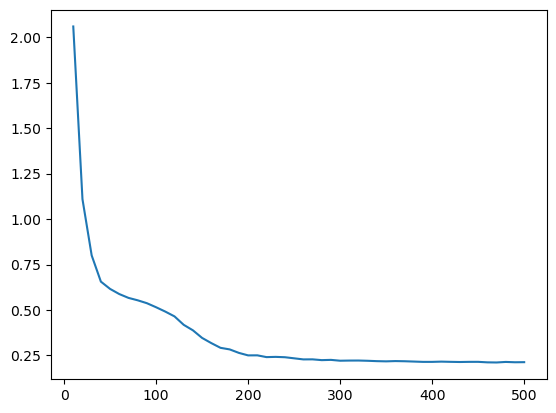

In [18]:
loss = [x["loss"] for x in loss_hist]
epochs = [x["epoch"] for x in loss_hist]
plt.plot(epochs, loss)

### Save Model: task 1

In [8]:
great_sub.save("california_task1")

### Load Model: task 1

In [ ]:
# great_sub = GReaT.load_from_dir("california_task1")

### Generate Samples: task 1

In [19]:
n_samples = 10
samples = great_sub.sample(n_samples, k=5, device="cuda")

In [32]:
samples

,cluster_string,cluster_string_count
0,rzDyf,56.0
1,ZEKnV,452.0
2,QCBAm,205.0
3,PwBpw,102.0
4,ZDRiQ,452.0
5,XoMna,747.0
6,wEKno,443.0
7,psNks,210.0
8,mmcxF,31.0
9,OCiHi,1113.0


In [24]:
samples.to_csv("samples_task1.csv")

### determine the total amount of a new cluster_string value.

In [31]:
test_sub = pd.read_csv('test_task1.csv') # where there are some slight changes e.g. 'rzDye' is introduced though it is similar to 'rzDyf'.
imputed_data = great_sub.impute(test_sub, max_length=200)
imputed_data

100%|██████████| 8/8 [00:00<00:00, 12.90it/s]


,cluster_string,cluster_string_count
0,rzDye,56.0
1,ZaKnV,1077.0
2,QCBAm,205.0
3,PwBpw,102.0
4,ZDRiQ,452.0
5,XoMna,747.0
6,wEKno,443.0
7,pNks,210.0


As you can see the total amount result is similar to the original even the input cluster string is changed a little.
Then with the amount given， sample from a complete table to fill a void table of row numbers being the obtained amount.
We test'rzDye' to see its content.

### Start Training: task 2.

In [ ]:
trainer_complete = great.fit(data) 


In [ ]:
loss_hist = trainer_complete.state.log_history.copy()
loss_hist.pop()

In [ ]:
loss = [x["loss"] for x in loss_hist]
epochs = [x["epoch"] for x in loss_hist]
plt.plot(epochs, loss)

### Save Model: task 2.

In [ ]:
great.save('calinfornia_task2')

### Generate Samples: a test before task 2.

In [ ]:
n_samples = 1000
samples = great.sample(n_samples, k=50, device="cuda")
samples

In [ ]:
samples.to_csv("california_before_task2.csv")

### Now, impute for task 2!

In [ ]:
test_complete = pd.read_csv('examples/test_complete.csv') 
imputed_data = great.impute(test_complete, max_length=200)
imputed_data